In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import dask
import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
from xhistogram.xarray import histogram

from matplotlib import cm
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

from osse import *
from canyon_utils import *
from sloped_MITgcm import *

In [3]:
run_dedalus = False # Dedalus only works on login nodes; MITgcm analysis has to work on compute nodes.

In [4]:
# Constant parameters

Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = 600.
delta_t = 60.

### Run / load 1D Dedalus simulations

In [5]:
T = 2500*86400.
names = ['default', 'f=0', 'Pr=230']

bbl_runs = {
    'default': {},
    'f=0': {'f': 0.},
    'Pr=230': {'σ': 230.},
    'theta=0': {'θ': 0.}
}
bbl_output = {}

for name, kwargs in bbl_runs.items():
    path = f"../../data/dedalus/transient/BBTRE-{name}_{T}.nc"

    if run_dedalus:
        from bbl import *
        bbl = bbl_exp_spinup(T=T, dt=T/100., **kwargs)
        bbl_output[name] = bbl_to_ds(bbl)
        bbl_output[name].to_netcdf(path)
        
    else:
        pathstr = path.split("/")[-1]
        print(f"Loading {pathstr}")
        bbl_output[name] = xr.open_dataset(path)

Loading BBTRE-default_216000000.0.nc
Loading BBTRE-f=0_216000000.0.nc
Loading BBTRE-Pr=230_216000000.0.nc
Loading BBTRE-theta=0_216000000.0.nc


In [8]:
experiments = ["idealized-plane", "idealized-canyon", "idealized-sill", "canyon-tracer"]
data = {}

In [9]:
nsnap = 20
dIter = 864000//60

for exp in experiments:
    data_dir = f"../../MITgcm/experiments/rotated_BBTRE_{exp}/run/"
    if exp == 'canyon-tracer':
        iters = np.arange(3603600, 3603600+10*dIter, dIter)
    else:
        iters = np.arange(3607200, 3607200+nsnap*dIter, dIter)
    temp = open_mdsdataset(data_dir, iters=iters, ignore_unknown_vars=True,prefix=["budgetDiag"], delta_t=delta_t)
    temp = add_thalweg(temp)
    temp = periodic_extend(temp, ['XC', 'XG'], dx, [0, 1])
    temp, grid = add_rotated_coords(temp, θ)
    temp = add_temp_budget(temp, grid, Γ, θ)
    temp = temp.reset_coords(['Depth'])
    print("Budget closes: ", check_temp_budget_closes(temp))
    
    data[exp] = {'ds': temp, 'grid': grid}

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xmitgcm/mds_store.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Budget closes:  True


/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xmitgcm/mds_store.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Budget closes:  True


/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xmitgcm/mds_store.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Budget closes:  True


/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xmitgcm/mds_store.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Budget closes:  True


In [10]:
budget_vars = [
    'total_tendency_TH_truth', 'total_tendency_TH',
    'diff_tendency_TH', 'adv_tendency_TH',
    'conv_adv_flux_anom_TH', 'conv_vert_adv_flux_TH'
]

for exp in experiments:   
    temp = data[exp]['ds']
    temp_intXY = temp[budget_vars].mean(dim='time').sum(dim=['XC','YC'], skipna=True).load()
    data[exp]['intXY'] = temp_intXY

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/env

idealized-plane
idealized-canyon
idealized-sill
canyon-tracer


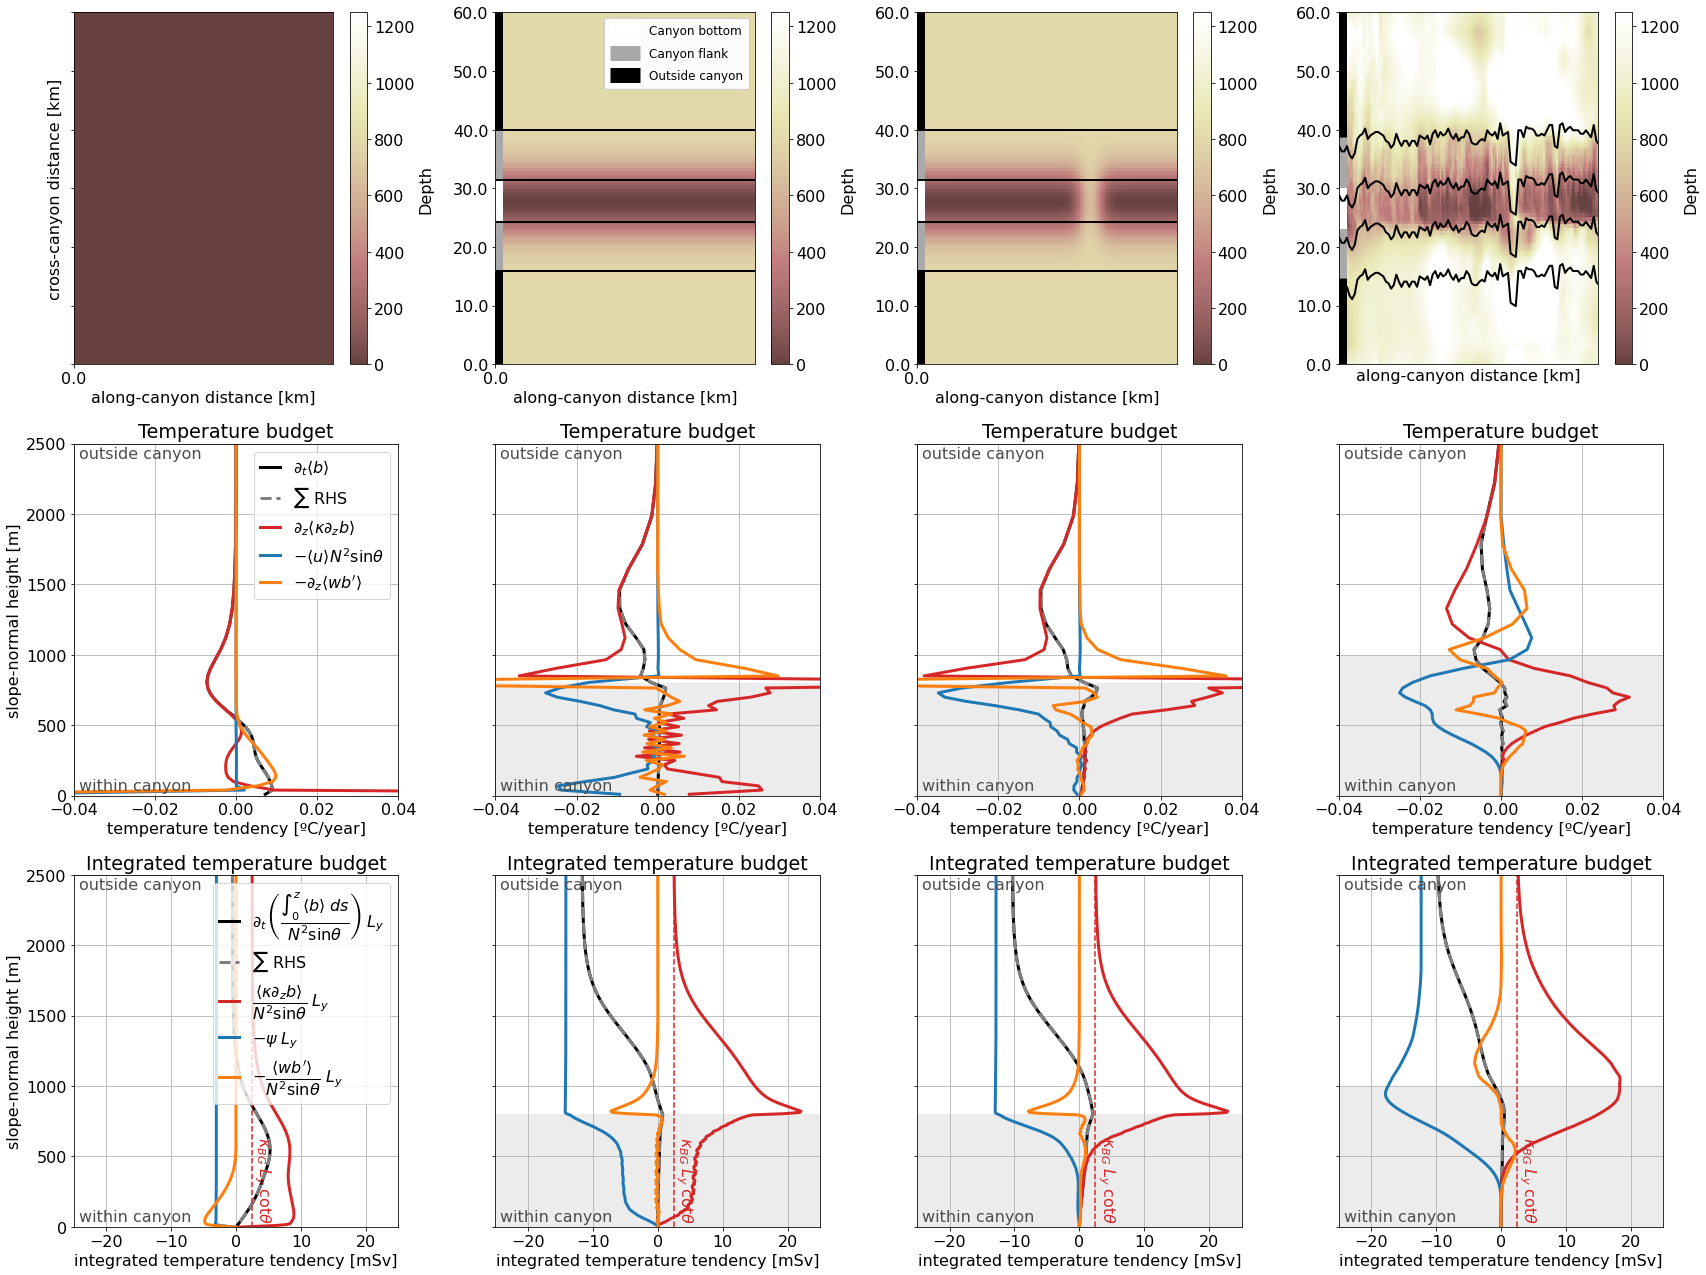

In [12]:
cmap = truncate_colormap(cm.get_cmap('pink'),0.1,1.)

fig, axes = plt.subplots(3,4, figsize=(24,18))

for i, (k,v) in enumerate(data.items()):
    print(k, end="\n")
    temp = v['ds']
    temp_intXY = v['intXY']

    temp_crest = irregular_section(temp[budget_vars+['Depth']], temp['j_thalweg'].values, width=35, invert_mask=True)
    canyon_height = temp['Depth'].max().values - (temp_crest['Depth'].mean(['XC', 'YC'], skipna=True).values)
    
    labels = {
        "total_tendency_TH_truth": r"$\partial_{t} \langle b \rangle$",
        "total_tendency_TH": r"$\sum$ RHS",
        "diff_tendency_TH": r"$\partial_{z} \langle \kappa \partial_{z} b \rangle$",
        "conv_adv_flux_anom_TH": r"$-\langle u \rangle N^{2} \sin{\theta}$",
        "conv_vert_adv_flux_TH": r"$-\partial_{z} \langle w b' \rangle$"
    }

    int_labels = {
        "total_tendency_TH_truth": r"$\partial_{t} \, \left(\dfrac{\int_{0}^{z}\, \langle b \rangle \; ds}{N^{2} \sin{\theta}} \right)\; L_{y}$",
        "total_tendency_TH": r"$\sum$ RHS",
        "diff_tendency_TH": r"$\dfrac{ \langle \kappa \partial_{z} b \rangle}{N^{2} \sin{\theta}}\; L_{y}$",
        "conv_adv_flux_anom_TH": r"$-\psi\; L_{y}$",
        "conv_vert_adv_flux_TH": r"$-\dfrac{\langle w b' \rangle}{N^{2} \sin{\theta}}\; L_{y}$"
    }

    Lx, Ly = temp.XC.size*dx, temp.YC.size*dy
    cint = k0*Γ*np.cos(θ)*Ly*Lx
    cbot = k1*Γ*np.cos(θ)*Ly*Lx

    linecolors = ["k", "grey", "C3", "C0", "C1"]
    for v, var in enumerate(labels.keys()):
        linestyle='-'; lw = 3;
        if var=="total_tendency_TH": linestyle="--"; lw=3;
        (temp_intXY[var]/(temp_intXY['drF']*Lx*Ly)*(86400.*365.)).coarsen(Z=5).mean().plot(ax=axes[1,i], y='Z', color=linecolors[v], label=labels[var], linestyle=linestyle, lw=lw)
        (np.cumsum(temp_intXY[var][::-1])[::-1]/(Γ*np.sin(θ)*Lx*Ly)*(Ly*1e-3)).plot(ax=axes[2,i], y='Z', color=linecolors[v], label=int_labels[var], linestyle=linestyle, lw=lw)

    axes[2,i].axvline(cint/(Γ*np.sin(θ)*Lx*Ly)*(Ly*1e-3), linestyle='--', color='C3')
    axes[2,i].annotate(r"$\kappa_{BG}\; L_{y}\; \cot{\theta}$", (0.55, 0.03), xycoords='axes fraction', color="C3", rotation=-90)

    axes[1,i].set_xlabel(r"temperature tendency [ºC/year]")
    axes[1,i].set_title("Temperature budget")
    axes[2,i].set_xlabel(r"integrated temperature tendency [mSv]")
    axes[2,i].set_title("Integrated temperature budget")
    axes[1,i].set_xticks(np.arange(-0.04, 0.05, 0.02))
    axes[1,i].set_xlim([-0.04, 0.04])
    axes[2,i].set_xlim([-25, 25])

    for ax in axes[1:3,i]:
        ax.set_ylim([0, 2500])
        ax.grid(True)
        ax.fill_between(ax.get_xlim(), [0., 0.], canyon_height*np.array([1, 1]), lw=5., alpha=0.15, facecolor="grey")
        if i==0:
            ax.set_ylabel("slope-normal height [m]")
            ax.legend(loc = "upper right", handlelength=1.25)
        else:
            ax.set_ylabel("")
            ax.set_yticklabels([])
        ax.annotate("within canyon", xy=(0.015, 0.015), xycoords="axes fraction", color=(0.3, 0.3, 0.3), fontsize=16)
        ax.annotate("outside canyon", xy=(0.015, 0.96), xycoords="axes fraction", color=(0.3, 0.3, 0.3), fontsize=16)

    ax = axes[0,i]
    ds = data[k]['ds']
    extra = 0.
    if i==0: extra=-200;
    q = (-ds['Depth']+ds.attrs['H']+extra).plot(ax=ax, cmap=cmap)
    q.set_clim([0, 1250])
    if i>0:
        x0 = 0.
        if i==3: x0 = 340e3;
        ax.plot([x0, x0], [ds['YC_thalweg'][0]-dx*6, ds['YC_thalweg'][0]+dx*6], "w", lw=15., solid_capstyle='butt', label='Canyon bottom')# gold
        ax.plot([x0, x0], [ds['YC_thalweg'][0]-dx*6, ds['YC_thalweg'][0]-dx*20], "darkgrey", lw=15., solid_capstyle='butt', label='Canyon flank')# b
        ax.plot([x0, x0], [ds['YC_thalweg'][0]+dx*6, ds['YC_thalweg'][0]+dx*20], "darkgrey", lw=15., solid_capstyle='butt') # C3
        ax.plot([x0, x0], [0.e3, ds['YC_thalweg'][0]-dx*20], "k", lw=15., solid_capstyle='butt', label='Outside canyon')
        ax.plot([x0, x0], [ds['YC_thalweg'][0]+dx*20, 60e3], "k", lw=15., solid_capstyle='butt')
        
        (ds['YC_thalweg']-dx*6).coarsen(XC=2).mean().plot(ax=ax, color='k', alpha=1., lw=2)
        (ds['YC_thalweg']+dx*6).coarsen(XC=2).mean().plot(ax=ax, color='k', alpha=1., lw=2)

        (ds['YC_thalweg']-dx*20).coarsen(XC=2).mean().plot(ax=ax, color='k', alpha=1., lw=2)
        (ds['YC_thalweg']+dx*20).coarsen(XC=2).mean().plot(ax=ax, color='k', alpha=1., lw=2)
        
        if i==1:
            axes[0,i].legend(loc='upper right', fontsize=12, handlelength=2.5, labelspacing=0.8, framealpha=0.95, borderpad=0.5)

    ax.set_xlim([0, 120e3])
    yticks = np.arange(0,70,10.)
    ax.set_yticks(yticks*1e3)
    ax.set_yticklabels(yticks)
    if i==3:
        add_to_xticks = 340.e3
        ax.set_xlim([add_to_xticks, add_to_xticks+120e3])
    else: add_to_xticks = 0.;
    xticks = np.arange(0,20,140.)+add_to_xticks
    ax.set_xticks(xticks*1e3)
    ax.set_xticklabels(xticks)
    if i==0:
        ax.set_ylabel("cross-canyon distance [km]")
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("")
    ax.set_xlabel("along-canyon distance [km]")
    
plt.tight_layout()
plt.savefig(f"../../figures/BBTRE/buoyancy_budget.png", dpi=150., bbox_inches="tight")

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


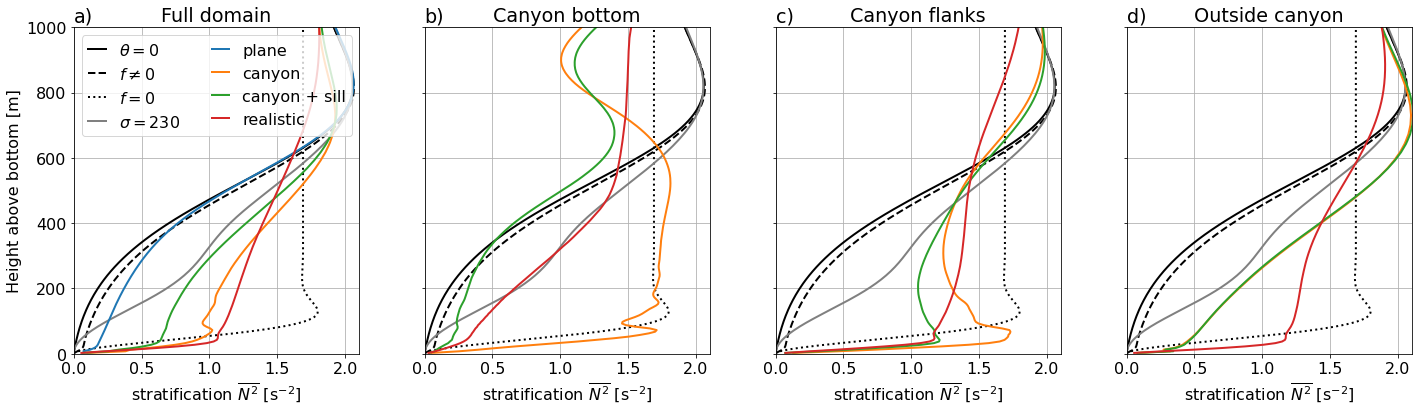

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

longnames = {
    'canyon-tracer': "realistic",
    'idealized-sill': "canyon + sill",
    'idealized-canyon': "canyon",
    'idealized-plane': "plane"
}
expcolors = {
    'canyon-tracer': "C3",
    'idealized-sill': "C2",
    'idealized-canyon': "C1",
    'idealized-plane': "C0"
}
titles = ['Full domain', 'Canyon bottom', 'Canyon flanks', 'Outside canyon']
labels = ['a)', 'b)', 'c)', 'd)']
for i, ax in enumerate(axes):
    bbl_output['theta=0']['bz'].plot(ax=ax, y='Zl', color="k", linestyle='-', label=r"$\theta = 0$", lw=2.)
    bbl_output['default']['bz'].plot(ax=ax, y='Zl', color="k", linestyle='--', label=r"$f\neq0$", lw=2.)
    bbl_output['f=0']['bz'].plot(ax=ax, y='Zl', color="k", linestyle=':', label=r"$f=0$", lw=2.)
    bbl_output['Pr=230']['bz'].plot(ax=ax, y='Zl', color="grey", label=r"$\sigma=230$", lw=2.)
    for exp in experiments:
        if (exp=='idealized-plane') & (i>0): continue
        ds = data[exp]['ds']
        grid = data[exp]['grid']
        Nsq = g*α*(Γ +
                (grid.diff(ds['THETA'].where(ds['hFacC']!=0.), 'Z', boundary='fill')) /
                grid.interp(-ds['drF'], 'Z', boundary='extend')
        )
        if i==1:
            Nsq = irregular_section(Nsq, ds['j_thalweg'].values, width=6)
        if i==2:
            bottom = irregular_section(Nsq, ds['j_thalweg'].values, width=6)
            outside = irregular_section(Nsq, ds['j_thalweg'].values, width=20, invert_mask=True)
            Nsq = Nsq.where((np.isnan(bottom)) & (np.isnan(outside)))
        if i==3:
            Nsq = irregular_section(Nsq, ds['j_thalweg'].values, width=20, invert_mask=True)
        ds = add_hab_coordinates(ds, grid, vert_coord='Zl', gridface='C')
        Nsq = Nsq.assign_coords({'Zl_habC': ds['Zl_habC']}).chunk({'Zl':-1})
        ds['Nsq_hab'] = hab_interp(Nsq, vert_coord='Zl')
        ds['Nsq_hab_av'] = ds['Nsq_hab'].mean(['time', 'XC', 'YC'], skipna=True)
        ds['Nsq_hab_av'].plot(ax=ax, y='hab', label=longnames[exp], color=expcolors[exp], lw=2.)
    ticks = np.arange(0., 2.5, 0.5)
    ax.set_xticks(ticks*1.e-6)
    ax.set_xticklabels(ticks)
    if i==0:
        ax.legend(loc='upper left', ncol=2, handlelength=1.1)
        ax.set_ylabel("Height above bottom [m]")
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    ax.set_xlabel("stratification $\overline{N^{2}}$ [s$^{-2}$]")
    ax.set_ylim(0, 1000)
    ax.set_xlim([0, 2.1e-6])
    ax.grid(True)
    ax.set_title(titles[i])
    ax.set_title(labels[i], loc='left')
plt.tight_layout()
plt.savefig(f"../../figures/BBTRE/hab_stratification.png", dpi=150., bbox_inches="tight")

In [ ]:
test1 = irregular_section(ds['Depth'], ds['j_thalweg'].values, width=20, invert_mask=True)
test2 = irregular_section(ds['Depth'], ds['j_thalweg'].values, width=6)

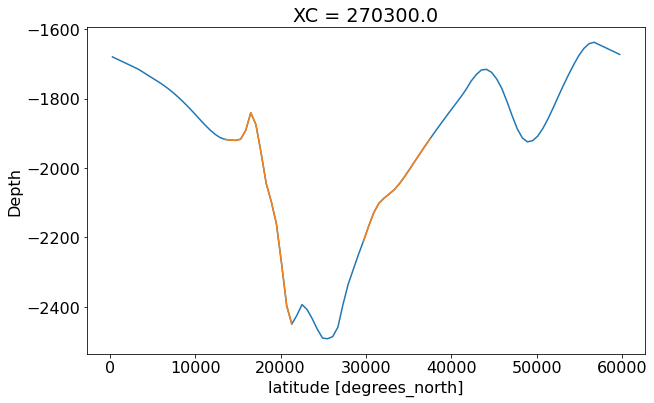

In [87]:
i = 450
(-ds['Depth']).isel(XC=i).plot()
(-ds['Depth'].where((np.isnan(test1)) & (np.isnan(test2)))).isel(XC=i).plot()

In [119]:
ds = data['idealized-sill']['ds']

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(0.0, 1200.0)

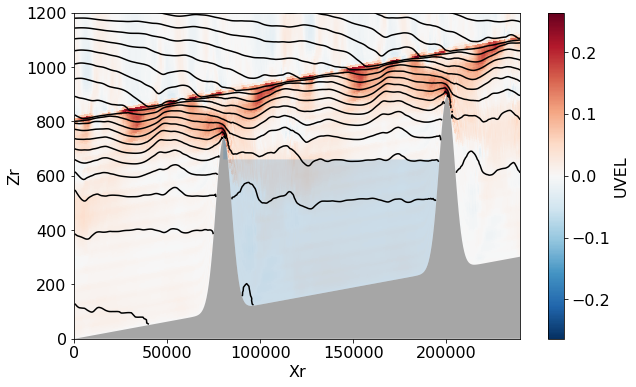

In [128]:
ds['UVEL'].sum('YC', skipna=True).mean('time').plot(x='Xr_U', y='Zr_U')
(ds['THETA']+ds['Zr']*Γ).where(ds['hFacC']!=0.).mean(['time','YC'], skipna=True).plot.contour(x='Xr', y='Zr', levels=np.arange(0., 3., 0.025), colors='k')
thalweg_dep = -ds['Depthr'].isel(YC=46) + ds.attrs['H']
plt.fill_between(ds['XC'], thalweg_dep*0., thalweg_dep, facecolor=nancol)
depression = [80e3,197e3]
plt.fill_between(ds['XC'].sel(XC=slice(*depression)), thalweg_dep.sel(XC=slice(*depression)), 0.*thalweg_dep.sel(XC=slice(*depression)) + 660., facecolor='C0', alpha=0.2)
plt.ylim([0, 1200])

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


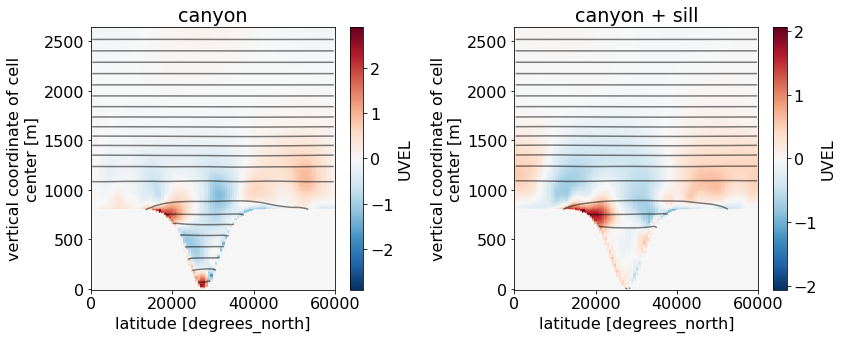

In [122]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
ds = data['idealized-canyon']['ds']
(ds['UVEL']*100).mean(dim='time').mean(dim=['XG'], skipna=True).plot()
(ds['THETA']+ds['Zr']*Γ).where(ds['hFacC']!=0.).mean(['time','XC'], skipna=True).plot.contour(levels=np.arange(0., 3., 0.1), colors='k', alpha=0.5)
plt.title("canyon")

plt.subplot(1,2,2)
ds = data['idealized-sill']['ds']
(ds['UVEL']*100).mean(dim='time').mean(dim=['XG'], skipna=True).plot()
(ds['THETA']+ds['Zr']*Γ).where(ds['hFacC']!=0.).mean(['time','XC'], skipna=True).plot.contour(levels=np.arange(0., 3., 0.1), colors='k', alpha=0.5)
plt.title("canyon + sill")

plt.tight_layout()

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


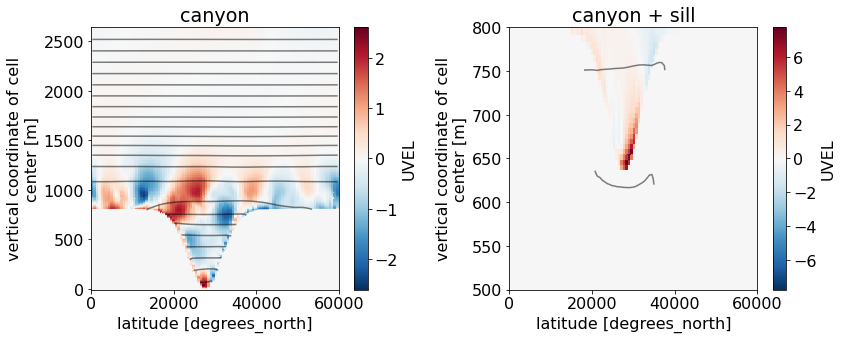

In [139]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
ds = data['idealized-canyon']['ds']
(ds['UVEL']*100).mean(dim='time').sel(XG=81e3, method='nearest').plot()
(ds['THETA']+ds['Zr']*Γ).where(ds['hFacC']!=0.).mean(['time','XC'], skipna=True).plot.contour(levels=np.arange(0., 3., 0.1), colors='k', alpha=0.5)
plt.title("canyon")

plt.subplot(1,2,2)
ds = data['idealized-sill']['ds']
(ds['UVEL']*100).mean(dim='time').sel(XG=81e3, method='nearest').plot()
(ds['THETA']+ds['Zr']*Γ).where(ds['hFacC']!=0.).mean(['time','XC'], skipna=True).plot.contour(levels=np.arange(0., 3., 0.1), colors='k', alpha=0.5)
plt.title("canyon + sill")

plt.ylim([500,800])

plt.tight_layout()

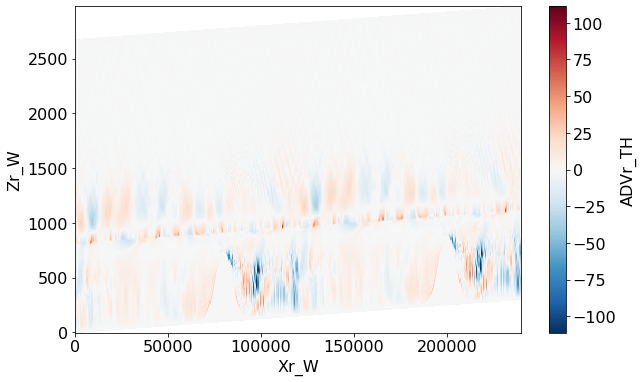

In [117]:
ds['ADVr_TH'].sum('YC').mean('time').plot(x='Xr_W', y='Zr_W')

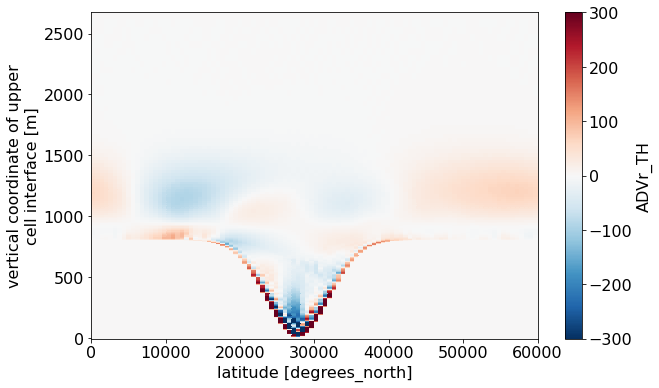

In [32]:
q = ds['ADVr_TH'].sum('XC').mean('time').plot()
q.set_clim([-300,300])

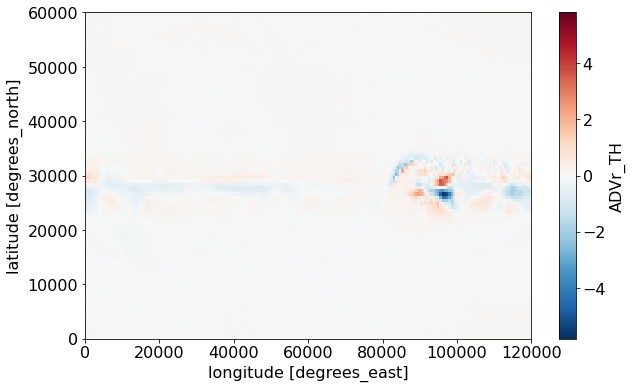

In [20]:
ds['ADVr_TH'].sel(Zl=slice(1500,0)).mean('Zl', skipna=True).mean('time').plot()

# Watermass transformation

In [ ]:
extend_multiples = [-5, 1]

wmt = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["budgetDiag"], delta_t=delta_t).isel(time=[-2, -1])
wmt = add_thalweg(wmt)
wmt = periodic_extend(wmt, ['XC', 'XG'], dx, extend_multiples)
wmt, wmt_grid = add_rotated_coords(wmt, θ)
wmt = add_temp_budget(wmt, wmt_grid, Γ, θ)

In [ ]:
wmt['THETA_BG_C'] = Γ*wmt['Zr']
wmt['θ'] = wmt['THETA'] + wmt['THETA_BG_C']
wmt['θ'] = wmt['θ'].where(wmt['hFacC'] != 0)

In [ ]:
wmt_in = wmt.where(wmt['Z'] < canyon_height)
wmt_out = wmt.where(wmt['Z'] >= canyon_height)
wmt_over = irregular_section(wmt[['θ', 'diff_tendency_TH']], wmt['j_thalweg'].values, width=25)
wmt_away = irregular_section(wmt[['θ', 'diff_tendency_TH']], wmt['j_thalweg'].values, width=25, invert_mask=True)

In [ ]:
wmt_over['Depth'].sel(XC=slice(0, 800*600)).sortby(wmt.YC).plot(x="XC")
plt.ylim([0, 60e3])

#### Full domain

In [ ]:
wmt_dict = {}

In [ ]:
dθ = 0.05
θlevs = np.arange(0.-dθ, 1.+dθ, dθ)

for label, ds in zip(['total', 'in', 'out', 'over', 'away'], [wmt, wmt_in, wmt_out, wmt_over, wmt_away]):
    wmt_dict[label] = {}
    
    mixing = ds['diff_tendency_TH'].fillna(0.)

    wmt_dict[label]['E_net'] = histogram(
        ds['θ'],
        bins=[θlevs],
        weights=mixing,
        dim=('XC', 'YC', 'Z',)
    ).load()/dθ;

    wmt_dict[label]['E_BBL'] = histogram(
        ds['θ'],
        bins=[θlevs],
        weights=mixing.where(mixing > 0., 0.),
        dim=('XC', 'YC', 'Z',)
    ).load()/dθ;

    wmt_dict[label]['E_SML'] = histogram(
        ds['θ'],
        bins=[θlevs],
        weights=mixing.where(mixing < 0., 0.),
        dim=('XC', 'YC', 'Z',)
    ).load()/dθ;

In [ ]:
plt.figure(figsize=(30, 2))

colors = ['k', 'r', 'b']
fig, axes = plt.subplots(1,5, figsize=(15, 5))
for i, (key, val) in enumerate(wmt_dict.items()):
    for j, (contr, da) in enumerate(val.items()):
        (da*1e-3).mean(dim='time').plot(y='θ_bin', ax=axes[i], color=colors[j])
        
    axes[i].set_xlim(-100, 100)
    axes[i].set_title(key)
    axes[i].grid(True)
    if i>0: axes[i].set_ylabel(""); axes[i].set_yticklabels;
    
plt.tight_layout()

In [ ]:
temp['Depth'].plot()


In [ ]:
wmt['θ'].isel(time=0).sel(XC=slice(-800*600, 200*600)).isel(YC=45).plot()
q = wmt['θ'].isel(time=0).sel(XC=slice(-800*600, 200*600)).isel(YC=45).plot.contour(levels=[0.25, 0.35], colors='k')
plt.clabel(q, inline=1, fontsize=10)
q = wmt['θ'].isel(time=0).sel(XC=slice(-800*600, 200*600)).isel(YC=45).plot.contour(levels=[0.55, 0.65], colors='k')
plt.clabel(q, inline=1, fontsize=10)
q = wmt['θ'].isel(time=0).sel(XC=slice(-800*600, 200*600)).isel(YC=45).plot.contour(levels=[0.12, 0.2], colors='w')
plt.clabel(q, inline=1, fontsize=10)